In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder \
    .appName("Project Milestone 2") \
    .getOrCreate()

24/11/24 20:41:06 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s17)
24/11/24 20:41:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 20:41:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
business_df = business_df.withColumnRenamed("name", "business_name")

24/11/24 20:41:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")

In [8]:
review_df = review_df.withColumnRenamed("stars", "star_rating").withColumnRenamed("cool", "cool_votes").withColumnRenamed("funny", "funny_votes").withColumnRenamed("useful", "useful_votes")

In [9]:
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

In [10]:
user_df = user_df.withColumnRenamed("review_count", "user_review_count").withColumnRenamed("name", "user_name")

In [11]:
airport_shuttles_az_business_df = business_df.filter(
    (business_df.categories.contains("Airport Shuttles")) & (business_df.state == "AZ")
)

In [12]:
review_df = review_df.withColumnRenamed("business_id", "review_business_id").withColumnRenamed("user_id", "review_user_id")

In [13]:
airport_shuttles_az_business_review_df = airport_shuttles_az_business_df.join(
    review_df, 
    airport_shuttles_az_business_df.business_id == review_df.review_business_id, 
    "inner"
)

In [14]:
airport_shuttles_az_business_review_user_df = airport_shuttles_az_business_review_df.join(
    user_df, 
    airport_shuttles_az_business_review_df.review_user_id == user_df.user_id, 
    "inner"
)

In [15]:
# airport_shuttles_az_business_review_user_df.show()

In [16]:
# airport_shuttles_az_business_review_user_df.printSchema()

In [17]:
airport_shuttles_az_business_review_user_df.createOrReplaceTempView("airport_shuttles_az_business_review_user")

In [18]:
query1 = """
SELECT 
    user_id, user_name,
    COUNT(review_id) AS total_reviews,
    AVG(review_count) AS average_reviews_per_user
FROM 
    airport_shuttles_az_business_review_user
GROUP BY 
    user_id, user_name
ORDER BY 
    total_reviews DESC
LIMIT 10;
"""
result1_df = spark.sql(query1)
result1_df.show()

+--------------------+---------+-------------+------------------------+
|             user_id|user_name|total_reviews|average_reviews_per_user|
+--------------------+---------+-------------+------------------------+
|hxkx6UYltlrjKmow0...|  Richard|            4|                   38.75|
|hdLToS_AFNyqUzzcZ...|        D|            2|                    35.5|
|PLe2TWa02y1C7gnHE...|      Ess|            2|                    80.0|
|h8yn-q-yMwcB9o9Yp...|     Kurt|            2|                    43.0|
|ifbY7DlrQep2hxR8W...| Jennifer|            2|                    43.0|
|6q5HEqARkPW8XJ1Kd...|     Mike|            2|                     5.0|
|sOGVdjTzOMNMlVs1R...|     Dave|            2|                    47.5|
|0UJDp8VclFMcuCdyC...|    Susan|            2|                    17.0|
|jZO9ZG_9mf34bEzpZ...|     Mary|            2|                    41.0|
|aeZ4drQkBXcqt8oft...|   Connie|            2|                    31.0|
+--------------------+---------+-------------+------------------

In [19]:
query2 = """
SELECT 
    user_id, user_name,
    AVG(stars) AS average_rating
FROM 
    airport_shuttles_az_business_review_user
GROUP BY 
    user_id, user_name
ORDER BY 
    average_rating DESC
LIMIT 10;
"""
result2_df = spark.sql(query2)
result2_df.show()

+--------------------+---------+--------------+
|             user_id|user_name|average_rating|
+--------------------+---------+--------------+
|h1mqMg_yZYFsZyUwX...|    Jason|           5.0|
|sBHS_gL9aTaTbTAcd...|    Chris|           5.0|
|4GMA5-2pJUkJEMP13...|      Liz|           5.0|
|GNI3DTA6MxKRCEra7...| Margaret|           5.0|
|m87M-ni_44265eC9N...|    Cliff|           5.0|
|uL_O5y1kWF9fKfqm3...|     Jeff|           5.0|
|UPw4i_dJGhD816fO2...|    Kathy|           5.0|
|rTkuBc-7QRMi6RyMl...|    Jenny|           5.0|
|FoqH7EIs8C6RfLBrK...|   Glenna|           5.0|
|8xRPstWwX3i6H1Ir0...|  Suzanne|           5.0|
+--------------------+---------+--------------+



In [20]:
query3 = """
SELECT 
    user_id, user_name,
    SUM(CASE WHEN stars = 1 THEN 1 ELSE 0 END) AS one_star_reviews,
    SUM(CASE WHEN stars = 2 THEN 1 ELSE 0 END) AS two_star_reviews,
    SUM(CASE WHEN stars = 3 THEN 1 ELSE 0 END) AS three_star_reviews,
    SUM(CASE WHEN stars = 4 THEN 1 ELSE 0 END) AS four_star_reviews,
    SUM(CASE WHEN stars = 5 THEN 1 ELSE 0 END) AS five_star_reviews,
    SUM(CASE WHEN stars IN (1, 2, 3, 4, 5) THEN 1 ELSE 0 END) AS total_reviews
FROM 
    airport_shuttles_az_business_review_user
GROUP BY 
    user_id, user_name
HAVING 
    total_reviews > 0
ORDER BY 
    total_reviews DESC
LIMIT 10;
"""
result3_df = spark.sql(query3)
result3_df.show()

+--------------------+---------+----------------+----------------+------------------+-----------------+-----------------+-------------+
|             user_id|user_name|one_star_reviews|two_star_reviews|three_star_reviews|four_star_reviews|five_star_reviews|total_reviews|
+--------------------+---------+----------------+----------------+------------------+-----------------+-----------------+-------------+
|FeKl8hk3YJEDpSI9u...|     Ceci|               0|               0|                 0|                0|                2|            2|
|0P1NJINYHPx6iv00c...|    Nancy|               0|               0|                 0|                0|                2|            2|
|rQ996HkaGPnVrheBM...|    Becky|               0|               0|                 0|                0|                1|            1|
|hj4mHoNIFUnZV11dL...|    Kelly|               0|               0|                 0|                0|                1|            1|
|-ou42X2Ny3erNTjUm...|    Tommy|               0

In [21]:
query4 = """
SELECT user_id, user_name, COUNT(DISTINCT business_id) AS distinct_businesses_reviewed
FROM airport_shuttles_az_business_review_user
GROUP BY user_id, user_name
HAVING COUNT(DISTINCT business_id) > 1
ORDER BY distinct_businesses_reviewed DESC
"""
result4_df = spark.sql(query4)
result4_df.show()

+--------------------+---------+----------------------------+
|             user_id|user_name|distinct_businesses_reviewed|
+--------------------+---------+----------------------------+
|hxkx6UYltlrjKmow0...|  Richard|                           3|
|cynJeGho1spyXikHu...|    Aisha|                           2|
|6ObFF8-uKnOAlXuSH...| Isabella|                           2|
|hdLToS_AFNyqUzzcZ...|        D|                           2|
|03PwpkTJp58iIXvxS...|    Marco|                           2|
|sOGVdjTzOMNMlVs1R...|     Dave|                           2|
|PhS18gKbR5JUXQiGJ...|      Mel|                           2|
|TIlbuLIsGLISCoI9p...|  Jessica|                           2|
|0yrF14nWVAFeI0fG2...|    Betsy|                           2|
|bExwGidB4Sq9QqAHv...|    Linda|                           2|
|AniKUwEfQ_EkkZ8hf...|  Heather|                           2|
+--------------------+---------+----------------------------+



In [22]:
# airport_shuttles_az_business_review_df.printSchema()

In [23]:
# airport_shuttles_az_business_review_user_df.printSchema()

In [24]:
airport_shuttles_az_business_review_df.createOrReplaceTempView("business_reviews")
airport_shuttles_az_business_review_user_df.createOrReplaceTempView("user_reviews")

In [25]:
query5 = spark.sql("""
    SELECT 
        u.user_id,
        u.user_name,
        u.fans,
        u.user_review_count,
        u.elite,
        u.yelping_since,
        b.business_name,
        b.star_rating,
        b.text AS review_text,
        b.review_id
    FROM 
        user_reviews u
    INNER JOIN 
        business_reviews b
    ON 
        u.review_user_id = b.review_user_id
""")
query5.show(10, truncate=False)

+----------------------+---------+----+-----------------+--------------------------------------------------+-------------------+------------------------+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
query6 = """
SELECT
    br.business_name,
    br.city,
    br.state,
    br.stars AS business_average_stars,
    COUNT(ur.review_id) AS user_review_count,
    AVG(ur.star_rating) AS average_user_rating,
    SUM(ur.useful_votes) AS total_useful_votes,
    SUM(ur.funny_votes) AS total_funny_votes,
    SUM(ur.cool_votes) AS total_cool_votes
FROM
    business_reviews br
JOIN
    user_reviews ur
ON
    br.business_id = ur.business_id
WHERE
    br.review_count > 10
GROUP BY
    br.business_name, br.city, br.state, br.stars
ORDER BY
    total_useful_votes DESC
LIMIT 100;
"""
result6_df = spark.sql(query6)
result6_df.show(10, truncate=False)

+----------------------------------+------+-----+----------------------+-----------------+-------------------+------------------+-----------------+----------------+
|business_name                     |city  |state|business_average_stars|user_review_count|average_user_rating|total_useful_votes|total_funny_votes|total_cool_votes|
+----------------------------------+------+-----+----------------------+-----------------+-------------------+------------------+-----------------+----------------+
|Arizona Shuttle Service           |Tucson|AZ   |2.5                   |6724             |2.6463414634146343 |15498             |2706             |1886            |
|Arizona Stagecoach                |Tucson|AZ   |2.5                   |1936             |2.522727272727273  |6820              |1408             |1364            |
|FastPark & Relax                  |Tucson|AZ   |4.5                   |2209             |4.468085106382978  |4089              |517              |752             |
|Sky Harbo

In [27]:
query7 = """
    SELECT DISTINCT
        br.business_name,
        br.city,
        br.state,
        br.review_count,
        br.stars AS business_avg_stars,
        AVG(ur.average_stars) AS user_avg_stars,
        SUM(ur.user_review_count) AS user_review_count,
        SUM(ur.compliment_funny + ur.compliment_cool + ur.compliment_hot + ur.compliment_photos) AS total_compliments,
        MAX(ur.yelping_since) AS yelping_since
    FROM
        business_reviews br
    JOIN
        user_reviews ur
    ON
        br.business_id = ur.business_id
    WHERE
        br.state = 'AZ' AND
        br.city IN ('Tucson', 'Phoenix') AND
        ur.user_review_count > 100
    GROUP BY
        br.business_name,
        br.city,
        br.state,
        br.review_count,
        br.stars
    ORDER BY
        br.business_name
    LIMIT 20
"""
result7_df = spark.sql(query7)
result7_df.show(truncate=False)

+----------------------------------+------+-----+------------+------------------+------------------+-----------------+-----------------+-------------------+
|business_name                     |city  |state|review_count|business_avg_stars|user_avg_stars    |user_review_count|total_compliments|yelping_since      |
+----------------------------------+------+-----+------------+------------------+------------------+-----------------+-----------------+-------------------+
|24hr Express                      |Tucson|AZ   |23          |5.0               |4.299999999999998 |5382             |115              |2016-10-05 19:41:23|
|Adobe Transportation              |Tucson|AZ   |7           |4.5               |4.37              |2002             |525              |2015-07-05 19:00:19|
|Arizona Shuttle Service           |Tucson|AZ   |80          |2.5               |3.7666666666666635|345794           |152438           |2017-01-04 01:24:10|
|Arizona Stagecoach                |Tucson|AZ   |41       

In [28]:
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")

In [29]:
# airport_shuttles_az_business_df.printSchema()

In [30]:
# tip_df.printSchema()

In [31]:
# user_df.printSchema()

In [32]:
tip_df = tip_df.withColumnRenamed("business_id", "tip_business_id").withColumnRenamed("user_id", "tip_user_id")

In [33]:
airport_shuttles_az_business_tip_df = airport_shuttles_az_business_df.join(
    tip_df, 
    airport_shuttles_az_business_df.business_id == tip_df.tip_business_id, 
    "inner"
)

In [34]:
airport_shuttles_az_business_tip_user_df = airport_shuttles_az_business_tip_df.join(
    user_df, 
    airport_shuttles_az_business_tip_df.tip_user_id == user_df.user_id, 
    "inner"
)

In [35]:
# airport_shuttles_az_business_tip_df.printSchema()

In [36]:
# airport_shuttles_az_business_tip_user_df.printSchema()

In [37]:
airport_shuttles_az_business_tip_df.createOrReplaceTempView("business_tips")
airport_shuttles_az_business_tip_user_df.createOrReplaceTempView("user_tips")

In [38]:
query8 = """
    SELECT 
        b.business_name, 
        concat_ws(', ', collect_list(u.user_name)) AS user_names
    FROM 
        business_tips b
    JOIN 
        user_tips u
    ON 
        b.business_id = u.business_id
    GROUP BY 
        b.business_name
    LIMIT 5
"""
result8_df = spark.sql(query8)
result8_df.show(truncate=False)

+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_name               |user_names                                                                                                                                                                                                                                                                                                                             |
+----------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
query9 = """
    SELECT 
        b.business_name, 
        concat_ws(',', collect_list(DISTINCT u.user_name)) AS user_names,
        COUNT(u.user_id) AS num_users
    FROM 
        business_tips b
    JOIN 
        user_tips u
    ON 
        b.business_id = u.business_id
    GROUP BY 
        b.business_name
    ORDER BY 
        num_users DESC
    LIMIT 5
"""
result9_df = spark.sql(query9)
result9_df.show(truncate=50)

+----------------------------+---------------------------------------+---------+
|               business_name|                             user_names|num_users|
+----------------------------+---------------------------------------+---------+
|            FastPark & Relax|Brenner,Walt,Richard,Laura,Buck,D,David|       49|
|Jeannie's Van & Taxi Service|                Nj,Brittany,Jazzy,Grant|       36|
|                  Yellow Cab|                            Denis,Katie|       36|
|    Quick Park Quick Shuttle|                   Tera,Janine,Mark,Dee|       16|
|          Sky Harbor Express|                              Halle,kim|        4|
+----------------------------+---------------------------------------+---------+



In [40]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW elite_users AS
SELECT ut.*, bt.business_name AS business_name_bt
FROM user_tips ut
JOIN business_tips bt
ON ut.business_id = bt.business_id
WHERE ut.elite IS NOT NULL
""")

DataFrame[]

In [41]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW non_elite_users AS
SELECT ut.*, bt.business_name AS business_name_bt
FROM user_tips ut
JOIN business_tips bt
ON ut.business_id = bt.business_id
WHERE ut.elite IS NULL
""")

DataFrame[]

In [42]:
query10 = """
SELECT 
    'elite' AS user_type,
    COUNT(ut.user_id) AS num_elite_users,
    SUM(ut.review_count) AS total_reviews,
    AVG(ut.user_review_count) AS avg_user_reviews,
    SUM(ut.fans) AS total_fans,
    bt.business_name
FROM elite_users ut
JOIN business_tips bt
ON ut.business_id = bt.business_id
GROUP BY bt.business_name
UNION ALL
SELECT 
    'non-elite' AS user_type,
    COUNT(ut.user_id) AS num_non_elite_users,
    COALESCE(SUM(ut.review_count), 0) AS total_reviews_non_elite,
    COALESCE(AVG(ut.user_review_count), 0) AS avg_user_reviews_non_elite,
    COALESCE(SUM(ut.fans), 0) AS total_fans_non_elite,
    bt.business_name
FROM non_elite_users ut
JOIN business_tips bt
ON ut.business_id = bt.business_id
GROUP BY bt.business_name
"""
result10_df = spark.sql(query10)
result10_df.show(50)

+---------+---------------+-------------+------------------+----------+--------------------+
|user_type|num_elite_users|total_reviews|  avg_user_reviews|total_fans|       business_name|
+---------+---------------+-------------+------------------+----------+--------------------+
|    elite|              8|           40|               2.0|         8|King Pin Cab Company|
|    elite|              1|            7|             430.0|        40|Adobe Transportation|
|    elite|            343|        14749|128.57142857142858|      4410|    FastPark & Relax|
|    elite|              8|          184|               5.5|         0|        24hr Express|
|    elite|            216|         2808|21.333333333333332|       144|Jeannie's Van & T...|
|    elite|              1|           41|            1261.0|       211|  Arizona Stagecoach|
|    elite|              8|          168|             156.0|       232|Groome Transporta...|
|    elite|            216|         8640| 67.83333333333333|      3348

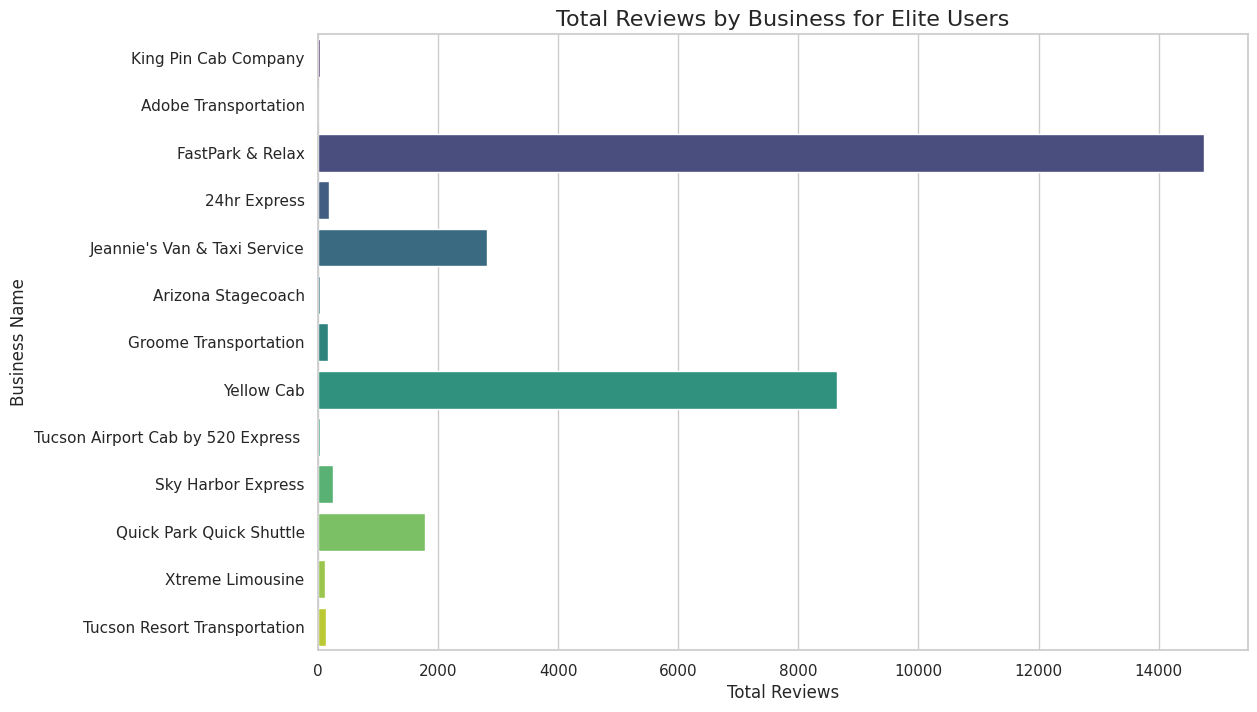

In [43]:
elite_data = result10_df.filter(result10_df.user_type == 'elite').toPandas()
plt.figure(figsize=(12, 8))
sns.barplot(x='total_reviews', y='business_name', data=elite_data, palette='viridis')
plt.title('Total Reviews by Business for Elite Users', fontsize=16)
plt.xlabel('Total Reviews', fontsize=12)
plt.ylabel('Business Name', fontsize=12)
plt.show()